In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
import plotly.graph_objects as go
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split

def plot_correlation_matrix(dataset, correlation_threshold: float = 0.7, figsize: tuple = (10, 8), annot: bool = True, title='Features Correlation Matrix'):
    _fig, ax = plt.subplots(figsize=figsize)

    correlation_matrix = dataset.corr(numeric_only=True)

    # Find pairs of highly correlated features
    highly_correlated_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
                colname_i = correlation_matrix.columns[i]
                colname_j = correlation_matrix.columns[j]
                highly_correlated_pairs.append((colname_i, colname_j, correlation_matrix.iloc[i, j]))

    sns.heatmap(correlation_matrix,  cmap='seismic', annot=annot, ax=ax)
    plt.tight_layout()
    ax.set_title(f'{title}', size=18)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    plt.show()

    # sort `highly_correlated_pairs` by correlation coefficient
    highly_correlated_pairs = sorted(highly_correlated_pairs, key=lambda x: abs(x[2]), reverse=True)

    print(f"{len(highly_correlated_pairs)} pairs with correlation coefficient above {correlation_threshold:.2f}:")

    for pair in highly_correlated_pairs:
        print(f"\t- `{pair[0]}` and `{pair[1]}`: correlation = {pair[2]:.2f}")

pd.set_option('display.max_rows', 100) # Set maximum displayed rows
pd.set_option('display.max_columns', 100) # Set maximum displayed columns
pd.set_option('display.max_colwidth', None)

In [2]:
meta_data = {
    "AcceptedCmp1": "1 if costumer accepted the offer in the 1st campaign, 0 otherwise",
    "AcceptedCmp2": "1 if costumer accepted the offer in the 2nd campaign, 0 otherwise",
    "AcceptedCmp3": "1 if costumer accepted the offer in the 3rd campaign, 0 otherwise",
    "AcceptedCmp4": "1 if costumer accepted the offer in the 4th campaign, 0 otherwise",
    "AcceptedCmp5": "1 if costumer accepted the offer in the 5th campaign, 0 otherwise",
    "Response (target)": "1 if costumer accepted the offer in the last campaign, 0 otherwise",
    "Complain": "1 if costumer complained in the last 2 years",
    "DtCustomer": "date of customer's enrollment with the company",
    "Education": "customer's level of education",
    "Marital": "customer's marital status",
    "Kidhome": "number of small children in customer's household",
    "Teenhome": "number of teenagers in customer's household",
    "Income": "customer's yearly household income",
    "MntFishProducts": "amount spent on fish products in the last 2 years",
    "MntMeatProducts": "amount spent on meat products in the last 2 years",
    "MntFruits": "amount spent on fruits in the last 2 years",
    "MntSweetProducts": "amount spent on sweet products in the last 2 years",
    "MntWines": "amount spent on wines in the last 2 years",
    "MntGoldProds": "amount spent on gold products in the last 2 years",
    "NumDealsPurchases": "number of purchases made with discount",
    "NumCatalogPurchases": "number of purchases made using catalogue",
    "NumStorePurchases": "number of purchases made directly in stores",
    "NumWebPurchases": "number of purchases made through company's web site",
    "NumWebVisitsMonth": "number of visits to company's web site in the last month",
    "Recency": "number of days since the last purchase"
}

metadata_df = pd.DataFrame.from_dict(meta_data, orient='index', columns=['Description'])
metadata_df.index.name = 'Feature'
metadata_df = metadata_df.reset_index()
metadata_df

,Feature,Description
0,AcceptedCmp1,"1 if costumer accepted the offer in the 1st campaign, 0 otherwise"
1,AcceptedCmp2,"1 if costumer accepted the offer in the 2nd campaign, 0 otherwise"
2,AcceptedCmp3,"1 if costumer accepted the offer in the 3rd campaign, 0 otherwise"
3,AcceptedCmp4,"1 if costumer accepted the offer in the 4th campaign, 0 otherwise"
4,AcceptedCmp5,"1 if costumer accepted the offer in the 5th campaign, 0 otherwise"
5,Response (target),"1 if costumer accepted the offer in the last campaign, 0 otherwise"
6,Complain,1 if costumer complained in the last 2 years
7,DtCustomer,date of customer's enrollment with the company
8,Education,customer's level of education
9,Marital,customer's marital status


In [3]:
df = pd.read_csv('ifood_dataset.csv').sort_index(axis=1)
df.head()

,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Complain,Dt_Customer,Education,ID,Income,Kidhome,Marital_Status,MntFishProducts,MntFruits,MntGoldProds,MntMeatProducts,MntSweetProducts,MntWines,NumCatalogPurchases,NumDealsPurchases,NumStorePurchases,NumWebPurchases,NumWebVisitsMonth,Recency,Response,Teenhome,Year_Birth,Z_CostContact,Z_Revenue
0,0,0,0,0,0,0,2012-09-04,Graduation,5524,58138.0,0,Single,172,88,88,546,88,635,10,3,4,8,7,58,1,0,1957,3,11
1,0,0,0,0,0,0,2014-03-08,Graduation,2174,46344.0,1,Single,2,1,6,6,1,11,1,2,2,1,5,38,0,1,1954,3,11
2,0,0,0,0,0,0,2013-08-21,Graduation,4141,71613.0,0,Together,111,49,42,127,21,426,2,1,10,8,4,26,0,0,1965,3,11
3,0,0,0,0,0,0,2014-02-10,Graduation,6182,26646.0,1,Together,10,4,5,20,3,11,0,2,4,2,6,26,0,0,1984,3,11
4,0,0,0,0,0,0,2014-01-19,PhD,5324,58293.0,1,Married,46,43,15,118,27,173,3,5,6,5,5,94,0,0,1981,3,11


In [4]:
df = df.drop_duplicates()

In [5]:
cost_of_campaign = 3 * len(df)
revenue_campaign = 11 * len(df[df['Response'] == 1])

print(f"cost_of_campaign = {cost_of_campaign} MU")
print(f"revenue_campaign = {revenue_campaign} MU")
print(f"profit_campaign = {revenue_campaign - cost_of_campaign} MU")

cost_of_campaign = 6720 MU
revenue_campaign = 3674 MU
profit_campaign = -3046 MU


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AcceptedCmp1         2240 non-null   int64  
 1   AcceptedCmp2         2240 non-null   int64  
 2   AcceptedCmp3         2240 non-null   int64  
 3   AcceptedCmp4         2240 non-null   int64  
 4   AcceptedCmp5         2240 non-null   int64  
 5   Complain             2240 non-null   int64  
 6   Dt_Customer          2240 non-null   object 
 7   Education            2240 non-null   object 
 8   ID                   2240 non-null   int64  
 9   Income               2216 non-null   float64
 10  Kidhome              2240 non-null   int64  
 11  Marital_Status       2240 non-null   object 
 12  MntFishProducts      2240 non-null   int64  
 13  MntFruits            2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  MntMeatProducts      2240 non-null   i

In [7]:
df.isna().sum()

AcceptedCmp1            0
AcceptedCmp2            0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
Complain                0
Dt_Customer             0
Education               0
ID                      0
Income                 24
Kidhome                 0
Marital_Status          0
MntFishProducts         0
MntFruits               0
MntGoldProds            0
MntMeatProducts         0
MntSweetProducts        0
MntWines                0
NumCatalogPurchases     0
NumDealsPurchases       0
NumStorePurchases       0
NumWebPurchases         0
NumWebVisitsMonth       0
Recency                 0
Response                0
Teenhome                0
Year_Birth              0
Z_CostContact           0
Z_Revenue               0
dtype: int64

In [8]:
df.head()

,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Complain,Dt_Customer,Education,ID,Income,Kidhome,Marital_Status,MntFishProducts,MntFruits,MntGoldProds,MntMeatProducts,MntSweetProducts,MntWines,NumCatalogPurchases,NumDealsPurchases,NumStorePurchases,NumWebPurchases,NumWebVisitsMonth,Recency,Response,Teenhome,Year_Birth,Z_CostContact,Z_Revenue
0,0,0,0,0,0,0,2012-09-04,Graduation,5524,58138.0,0,Single,172,88,88,546,88,635,10,3,4,8,7,58,1,0,1957,3,11
1,0,0,0,0,0,0,2014-03-08,Graduation,2174,46344.0,1,Single,2,1,6,6,1,11,1,2,2,1,5,38,0,1,1954,3,11
2,0,0,0,0,0,0,2013-08-21,Graduation,4141,71613.0,0,Together,111,49,42,127,21,426,2,1,10,8,4,26,0,0,1965,3,11
3,0,0,0,0,0,0,2014-02-10,Graduation,6182,26646.0,1,Together,10,4,5,20,3,11,0,2,4,2,6,26,0,0,1984,3,11
4,0,0,0,0,0,0,2014-01-19,PhD,5324,58293.0,1,Married,46,43,15,118,27,173,3,5,6,5,5,94,0,0,1981,3,11


In [9]:
df.describe().sort_index(axis=1)

,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Complain,ID,Income,Kidhome,MntFishProducts,MntFruits,MntGoldProds,MntMeatProducts,MntSweetProducts,MntWines,NumCatalogPurchases,NumDealsPurchases,NumStorePurchases,NumWebPurchases,NumWebVisitsMonth,Recency,Response,Teenhome,Year_Birth,Z_CostContact,Z_Revenue
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0
mean,0.064286,0.013393,0.072768,0.074554,0.072768,0.009375,5592.159821,52247.251354,0.444196,37.525446,26.302232,44.021875,166.950000,27.062946,303.935714,2.662054,2.325000,5.790179,4.084821,5.316518,49.109375,0.149107,0.506250,1968.805804,3.0,11.0
std,0.245316,0.114976,0.259813,0.262728,0.259813,0.096391,3246.662198,25173.076661,0.538398,54.628979,39.773434,52.167439,225.715373,41.280498,336.597393,2.923101,1.932238,3.250958,2.778714,2.426645,28.962453,0.356274,0.544538,11.984069,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1893.000000,3.0,11.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2828.250000,35303.000000,0.000000,3.000000,1.000000,9.000000,16.000000,1.000000,23.750000,0.000000,1.000000,3.000000,2.000000,3.000000,24.000000,0.000000,0.000000,1959.000000,3.0,11.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5458.500000,51381.500000,0.000000,12.000000,8.000000,24.000000,67.000000,8.000000,173.500000,2.000000,2.000000,5.000000,4.000000,6.000000,49.000000,0.000000,0.000000,1970.000000,3.0,11.0
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8427.750000,68522.000000,1.000000,50.000000,33.000000,56.000000,232.000000,33.000000,504.250000,4.000000,3.000000,8.000000,6.000000,7.000000,74.000000,0.000000,1.000000,1977.000000,3.0,11.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11191.000000,666666.000000,2.000000,259.000000,199.000000,362.000000,1725.000000,263.000000,1493.000000,28.000000,15.000000,13.000000,27.000000,20.000000,99.000000,1.000000,2.000000,1996.000000,3.0,11.0


- No more than 2 children
- Last purchase is less than 100 days
- Slight increase of people accepting campaings. Still, less than 8% accepted them.
- Very small amount of people complaining, less than 1%.
- On average, clients are client for more than 4 years
- The average client age is 55 years old
- Clients spend on average R$605
- On average, clients have one child
- On average, clients accepted 2x more the last campaign compared to campaign 5
- On average, rounding above, ~6 access to store purchases, ~3 catalogue, and ~4 website purchases. ~2 purchases with discount on average. On average, ~13 total purchases.


## Feature Engineering
Let's create some variables to help with our analysis

In [10]:
df['MntRegProds'] = (df['MntWines'] + df['MntMeatProducts'] + df['MntFruits'] + df['MntFishProducts'] + df['MntSweetProducts'] - df['MntGoldProds'])

In [11]:
df['TotalSpending'] = df[['MntWines', 'MntMeatProducts', 'MntFruits', 'MntFishProducts', 'MntSweetProducts']].sum(axis=1)

In [12]:
df['TotalSpending'].describe()

count    2240.000000
mean      561.776339
std       576.613680
min         4.000000
25%        55.000000
50%       341.000000
75%       964.000000
max      2491.000000
Name: TotalSpending, dtype: float64

In [13]:
current_year = 2014

today = pd.Timestamp(pd.to_datetime(f'{current_year}-12-12', format='%Y-%m-%d'))
dt_column = pd.to_datetime(df.Dt_Customer, format='%Y-%m-%d')
df["Dt_Customer"] = dt_column
days_with_company = (today - df['Dt_Customer']).dt.days
df['Days_With_Company'] = days_with_company

df.drop(columns=["Dt_Customer"], inplace=True)

In [14]:
df["NumTotalPurchases"] = df["NumCatalogPurchases"] + df["NumStorePurchases"] + df["NumWebPurchases"]

In [15]:
df["NumAcceptedCmp"] = df["AcceptedCmp1"] + df["AcceptedCmp2"] + df["AcceptedCmp3"] + df["AcceptedCmp4"] + df["AcceptedCmp5"]

In [16]:
df["CustomerAge"] = current_year - df["Year_Birth"]

def map_age(x):
    if x < 40:
        return 0 # 'Young'
    elif x < 60:
        return 1 # 'MiddleAge'
    else:
        return 2 # 'Old'

df["AgeGroup"] = df["CustomerAge"].map(map_age)

In [17]:
df["NumChildren"] = df["Kidhome"] + df["Teenhome"]

In [18]:
def map_income(x):
    num_months_year = 12
    min_salary = 1412
    if x <= min_salary * num_months_year:
        return 0 # 'E'
    elif x <= 3 * min_salary * num_months_year:
        return 1 # 'D'
    elif x <= 5 * min_salary * num_months_year:
        return 2 # 'C'
    elif x <= 15 * min_salary * num_months_year:
        return 3 # 'B'
    else:
        return 4 # 'A'

df["SalaryRange"] = df["Income"].map(map_income)

## Analysis

Check if values within binary columns are valid

In [19]:
campaign_columns = ["AcceptedCmp1",	"AcceptedCmp2", "AcceptedCmp3",	"AcceptedCmp4",	"AcceptedCmp5", "Response"]

In [20]:
binary_cols = [
    "AcceptedCmp1",	"AcceptedCmp2", "AcceptedCmp3",	"AcceptedCmp4",	"AcceptedCmp5",	"Complain", 'Response'
]
for col in binary_cols:
    counter = df[col].value_counts().sort_index()
    assert list(counter.index) == [0, 1]

In [21]:
numeric_columns = [
    "Income",
    "Kidhome",
    "Teenhome",
    "MntWines",
    "MntMeatProducts",
    "MntFruits",
    "MntFishProducts",
    "MntSweetProducts",
    "MntGoldProds",
    "NumCatalogPurchases",
    "NumDealsPurchases",
    "NumStorePurchases",
    "NumWebPurchases",
    "NumWebVisitsMonth",
    "Recency",
    "Year_Birth",
    "Complain"
]

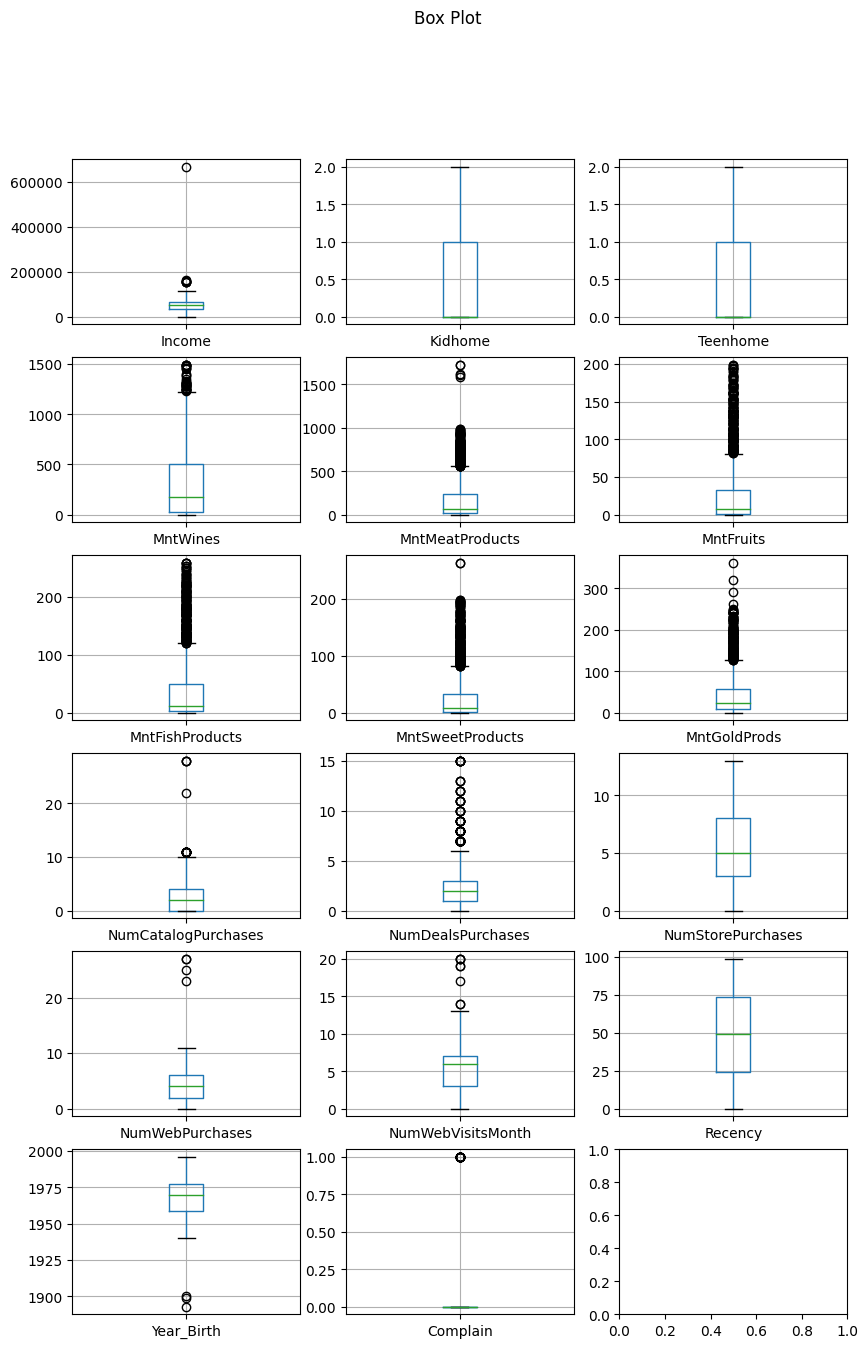

In [22]:
ncols = 3
nrows = int(np.ceil(len(numeric_columns) / ncols))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 15))

for i, column in enumerate(numeric_columns):
    df.boxplot(column=column, ax=ax[i // ncols, i % ncols])

fig.suptitle('Box Plot')
plt.show()

- There is some clear outliers in columns `Income`, `Year_Birth`. We'll drop those below.

In [23]:
df = df[df["Income"] <= 200000] # drop outliers

In [24]:
assert len(df['ID'].value_counts()) == len(df)

In [25]:
df['Education'].value_counts()

Graduation    1115
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64

In [26]:
df['Marital_Status'].value_counts()

Married     857
Together    572
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

- We'll change `Married` to `Together`, `Alone` to `Single`, and we'll drop `Absurd` and `YOLO`.

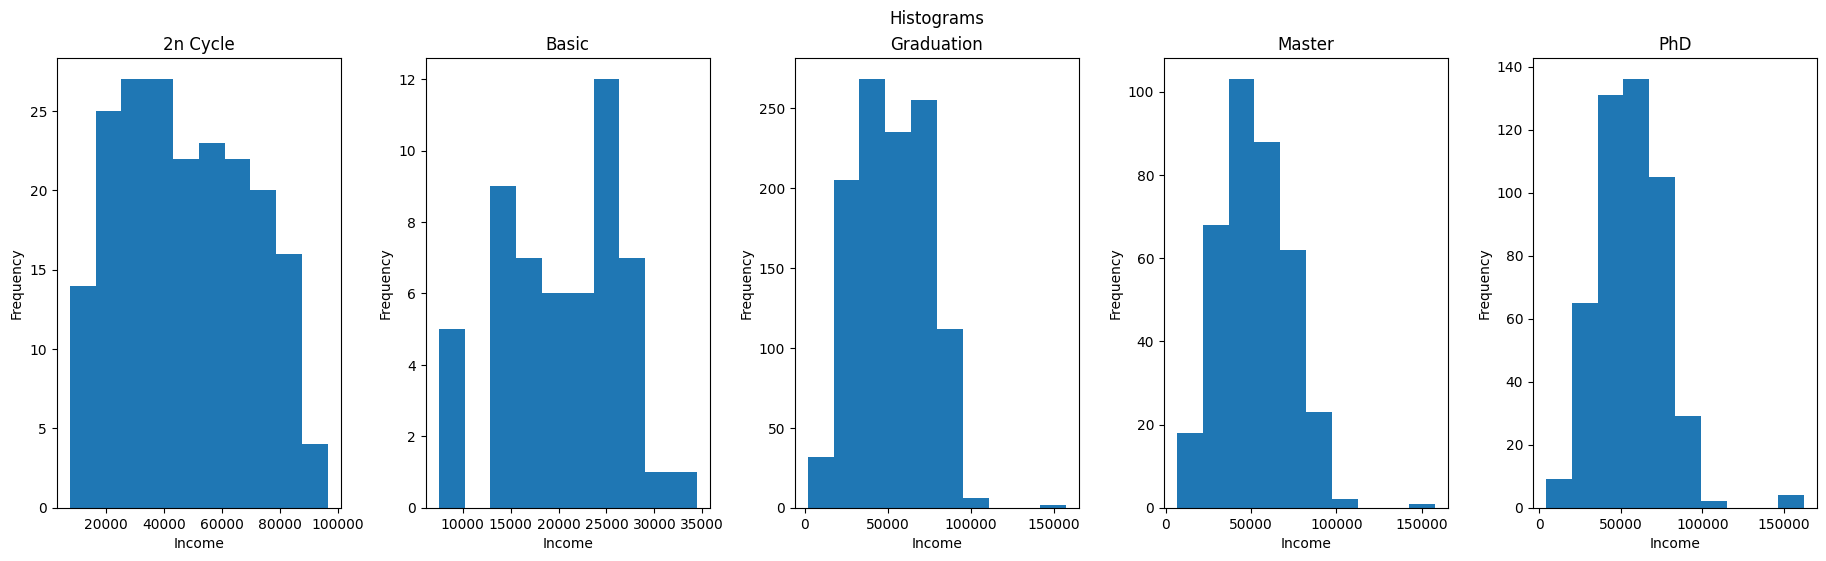

In [27]:
axs = df.hist(column="Income", by="Education", xrot=0, figsize=(22, 6), layout=(1, 5))

for ax in axs:
    ax.set_xlabel('Income')
    ax.set_ylabel('Frequency')

plt.suptitle('Histograms')
plt.show()

- Both Graduation and Master seems to have similar income
- PhD have a slightly better income than Master and Graduation
- Have a university course yields better income on average than a Basic or 2nd Cycle education

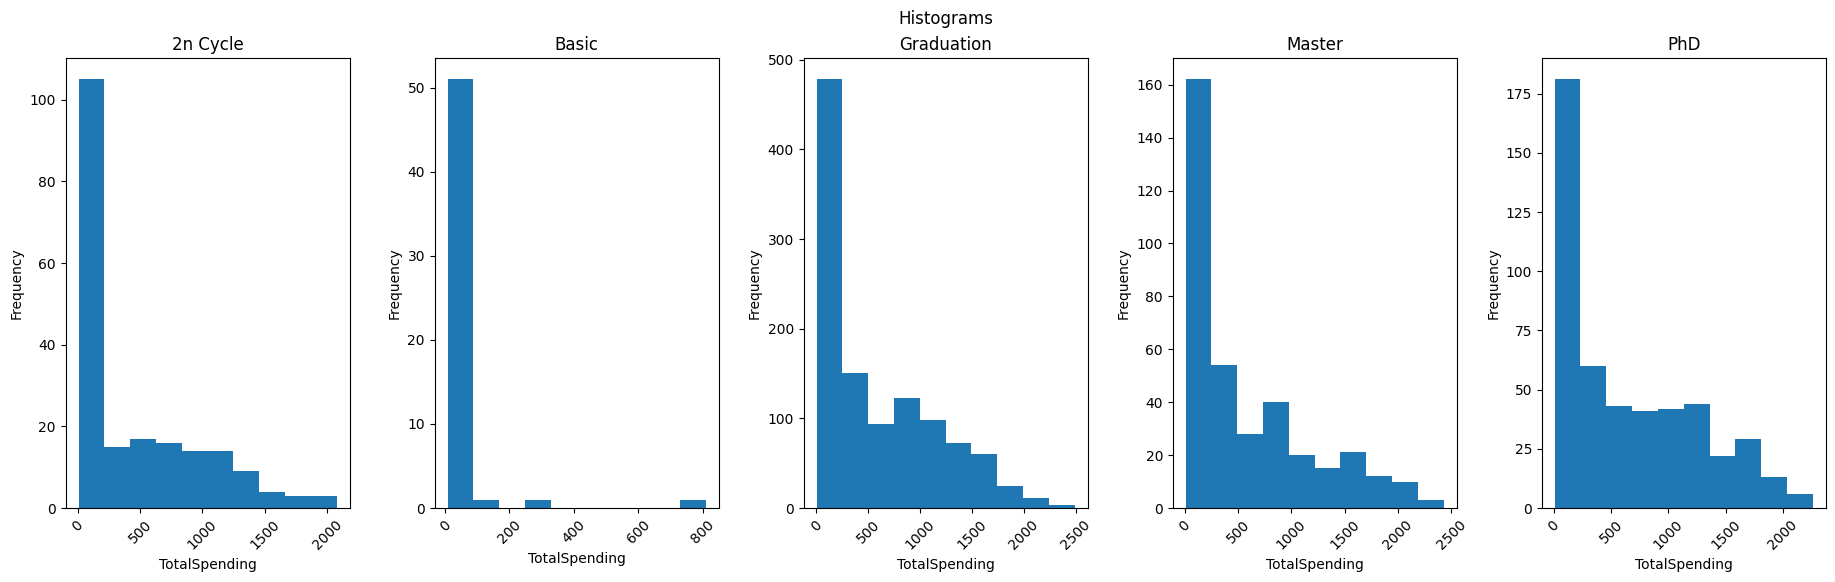

In [28]:
axs = df.hist(column="TotalSpending", by="Education", xrot=45, figsize=(22, 6), layout=(1, 5))

for ax in axs:
    ax.set_xlabel('TotalSpending')
    ax.set_ylabel('Frequency')
plt.suptitle('Histograms')
plt.show()

- People within 2nd Cycle tend to earn more than Basic cycle, which makes sense since it has higher education
- People earning more than R$200k yearly are negligible. We'll remove the outliers (more than R$200k). Because of this outlier, it's difficult to visualize `Graduation` plot.

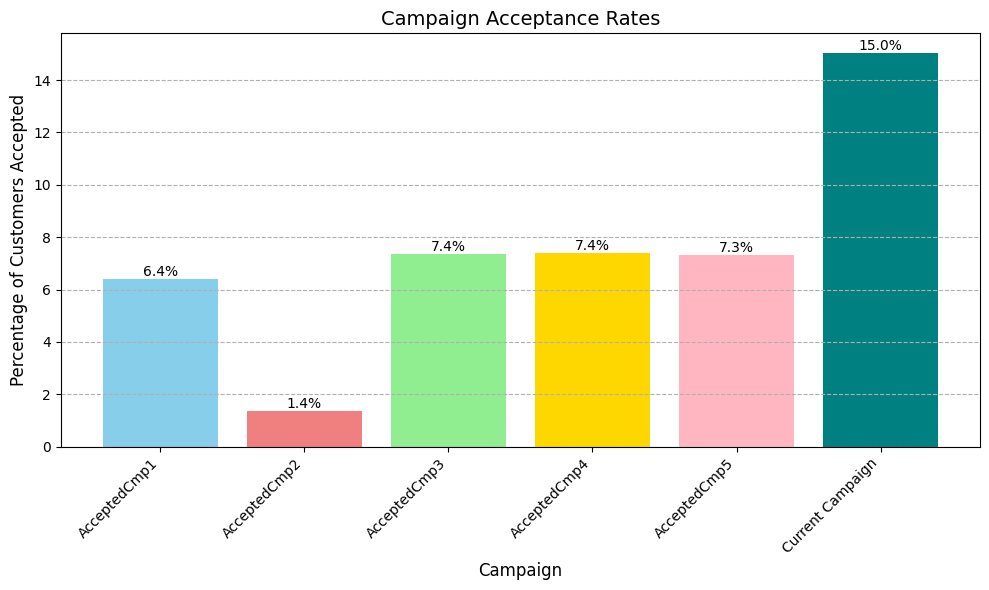

In [29]:
# Define the campaign columns
campaign_columns = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Current Campaign']

df["Current Campaign"] = df["Response"]

# Calculate the percentage of acceptance for each campaign
acceptance_rates = (df[campaign_columns].sum() / len(df)) * 100

# Create the bar plot
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
bars = plt.bar(campaign_columns, acceptance_rates, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'lightpink', 'teal']) # Specify custom colors

# Annotate each bar with its percentage
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}%', ha='center', va='bottom')


# Set plot labels and title
plt.xlabel('Campaign', fontsize=12)
plt.ylabel('Percentage of Customers Accepted', fontsize=12)
plt.title('Campaign Acceptance Rates', fontsize=14)
plt.grid(axis='y', linestyle='--') # Add a grid for y axis

# Adjust x ticks to avoid overlap
plt.xticks(rotation=45, ha='right')
plt.tight_layout() #Adjust layout to fit all labels

# Show the plot
plt.show()

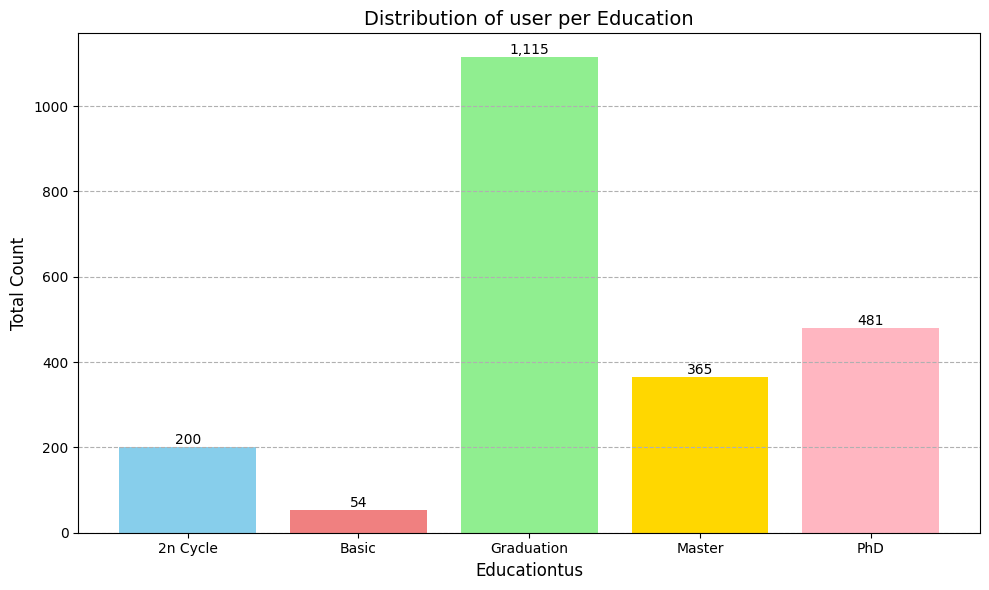

In [52]:
education = df.groupby(['Education']).size()

plt.figure(figsize=(10, 6))
ax = plt.bar(education.index, education.values, color = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'lightpink', 'teal'])

# Annotate each bar with its percentage
for bar in ax:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:,.0f}', ha='center', va='bottom')

plt.xlabel('Educationtus', fontsize=12)
plt.ylabel('Total Count', fontsize=12)
plt.title('Distribution of user per Education', fontsize=14)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

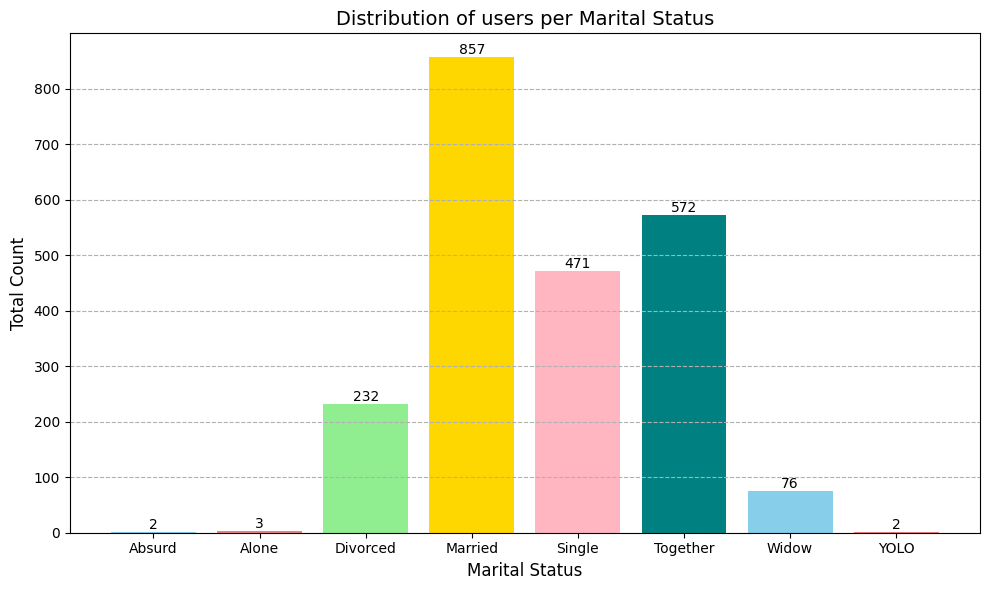

In [53]:
marital_status = df.groupby(['Marital_Status']).size()

plt.figure(figsize=(10, 6))
ax = plt.bar(marital_status.index, marital_status.values, color = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'lightpink', 'teal'])

# Annotate each bar with its percentage
for bar in ax:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:,.0f}', ha='center', va='bottom')

plt.xlabel('Marital Status', fontsize=12)
plt.ylabel('Total Count', fontsize=12)
plt.title('Distribution of users per Marital Status', fontsize=14)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

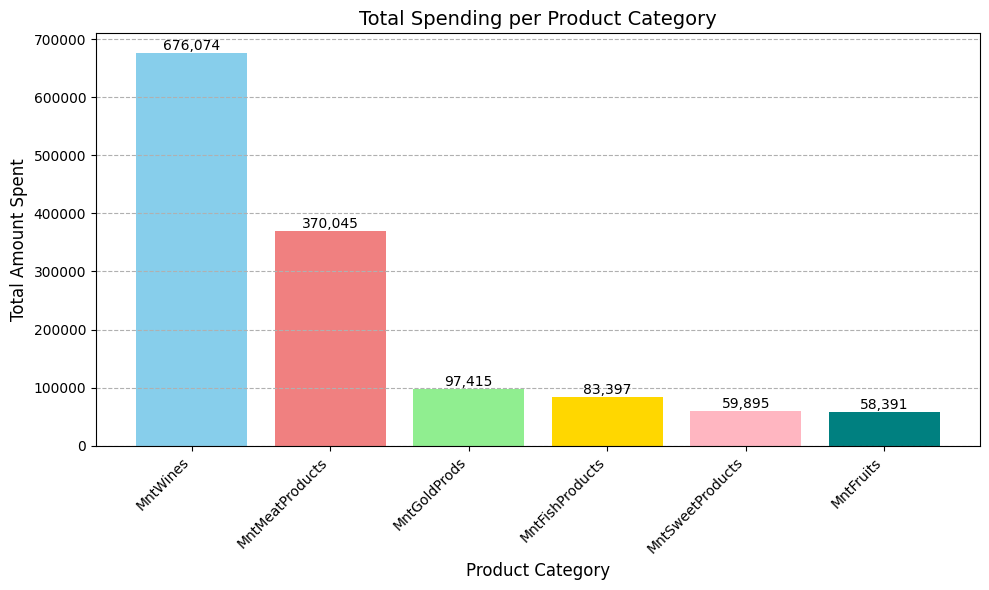

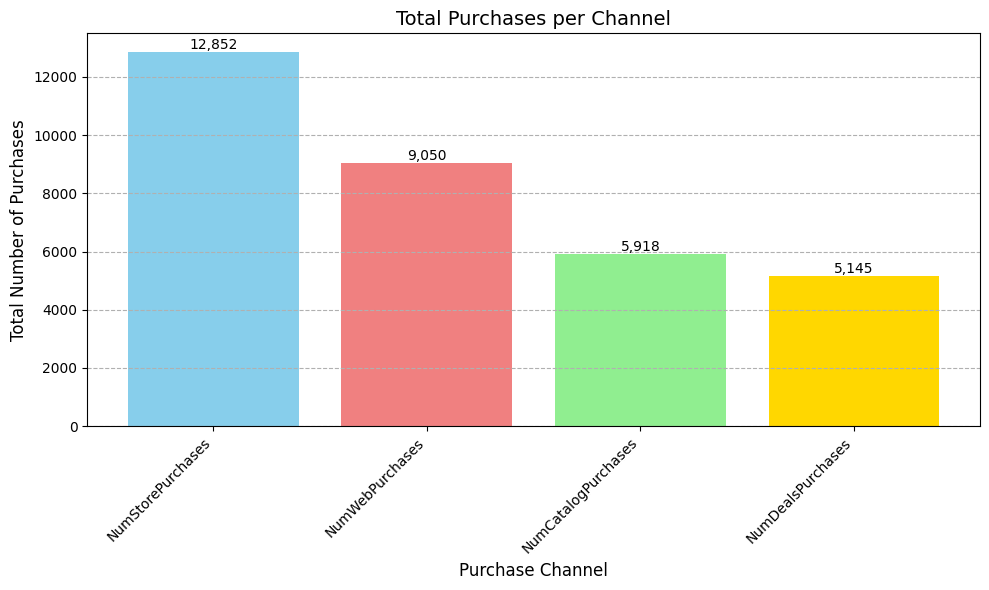

In [1015]:
# Fill missing income values with the median
median_income = df['Income'].median()

# 1. Bar chart: Purchase Amounts per Product
product_columns = [
    "MntFishProducts",
    "MntMeatProducts",
    "MntFruits",
    "MntSweetProducts",
    "MntWines",
    "MntGoldProds"
]

product_sums = df[product_columns].sum()
product_sums = product_sums.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
product_bars = plt.bar(product_sums.index, product_sums.values, color = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'lightpink', 'teal'])
# Annotate each bar with its percentage
for bar in product_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:,.0f}', ha='center', va='bottom')
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Total Amount Spent', fontsize=12)
plt.title('Total Spending per Product Category', fontsize=14)
plt.grid(axis='y', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# 2. Bar Chart: Purchases per Channel
channel_columns = [
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumWebPurchases",
    "NumDealsPurchases"
]

channel_sums = df[channel_columns].sum()
channel_sums = channel_sums.sort_values(ascending=False)


plt.figure(figsize=(10, 6))
channel_bars = plt.bar(channel_sums.index, channel_sums.values, color = ['skyblue', 'lightcoral', 'lightgreen', 'gold'])
# Annotate each bar with its value
for bar in channel_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:,.0f}', ha='center', va='bottom')

plt.xlabel('Purchase Channel', fontsize=12)
plt.ylabel('Total Number of Purchases', fontsize=12)
plt.title('Total Purchases per Channel', fontsize=14)
plt.grid(axis='y', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

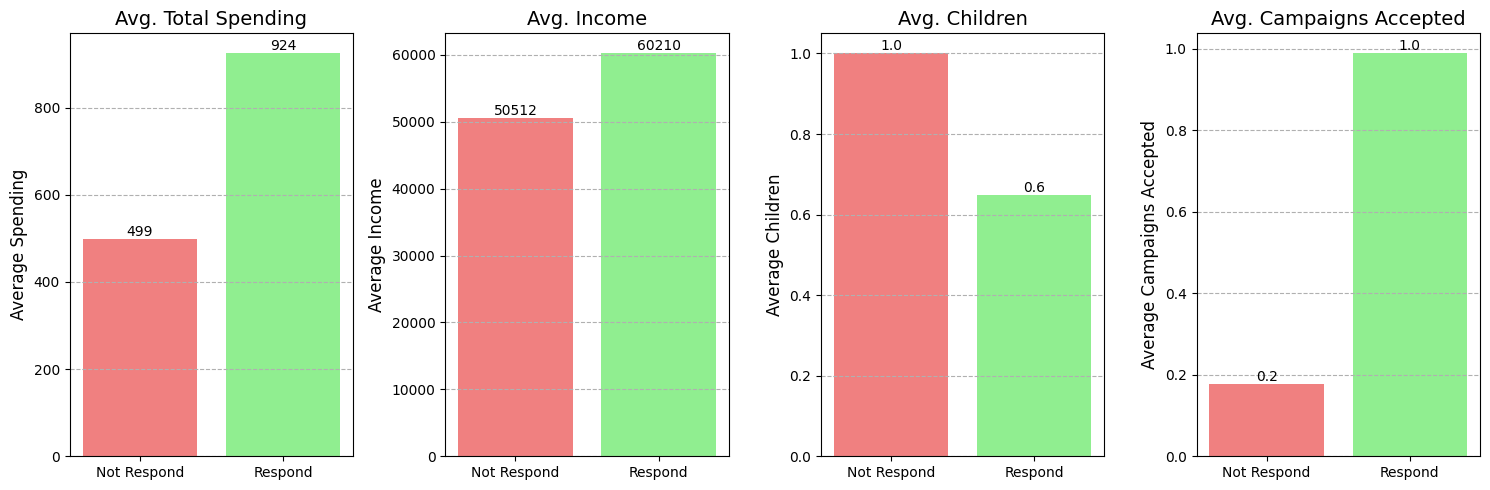

In [1016]:
median_income = df['Income'].median()

# Aggregate data
aggregated_data = df.groupby('Response').agg(
    avg_spending = pd.NamedAgg(column='TotalSpending', aggfunc='mean'),
    avg_income = pd.NamedAgg(column='Income', aggfunc='mean'),
    avg_children = pd.NamedAgg(column='NumChildren', aggfunc='mean'),
    avg_cmps = pd.NamedAgg(column='NumAcceptedCmp', aggfunc='mean'),
).reset_index()

# Create figure and axes
fig, axes = plt.subplots(1, 4, figsize=(15, 5))  # 1 row, 3 columns

# Define bar colors
colors = ['lightcoral', 'lightgreen']

# Create bar charts
axes[0].bar(aggregated_data['Response'].map({0:'Not Respond', 1:'Respond'}), aggregated_data['avg_spending'], color=colors)
axes[0].set_title('Avg. Total Spending', fontsize = 14)
axes[0].set_ylabel('Average Spending', fontsize=12)
axes[0].grid(axis='y', linestyle='--')
# Annotate each bar with its value
for bar in axes[0].containers:
    axes[0].bar_label(bar, fmt='{:.0f}')
axes[1].bar(aggregated_data['Response'].map({0:'Not Respond', 1:'Respond'}), aggregated_data['avg_income'], color=colors)
axes[1].set_title('Avg. Income', fontsize = 14)
axes[1].set_ylabel('Average Income', fontsize=12)
axes[1].grid(axis='y', linestyle='--')
# Annotate each bar with its value
for bar in axes[1].containers:
    axes[1].bar_label(bar, fmt='{:.0f}')
axes[2].bar(aggregated_data['Response'].map({0:'Not Respond', 1:'Respond'}), aggregated_data['avg_children'], color=colors)
axes[2].set_title('Avg. Children', fontsize = 14)
axes[2].set_ylabel('Average Children', fontsize=12)
axes[2].grid(axis='y', linestyle='--')
# Annotate each bar with its value
for bar in axes[2].containers:
    axes[2].bar_label(bar, fmt='{:.1f}')
axes[3].bar(aggregated_data['Response'].map({0:'Not Respond', 1:'Respond'}), aggregated_data['avg_cmps'], color=colors)
axes[3].set_title('Avg. Campaigns Accepted', fontsize = 14)
axes[3].set_ylabel('Average Campaigns Accepted', fontsize=12)
axes[3].grid(axis='y', linestyle='--')
# Annotate each bar with its value
for bar in axes[3].containers:
    axes[3].bar_label(bar, fmt='{:.1f}')

plt.tight_layout()
plt.show()

In [1017]:
aggregated_data["avg_children"]

0    1.000000
1    0.648649
Name: avg_children, dtype: float64

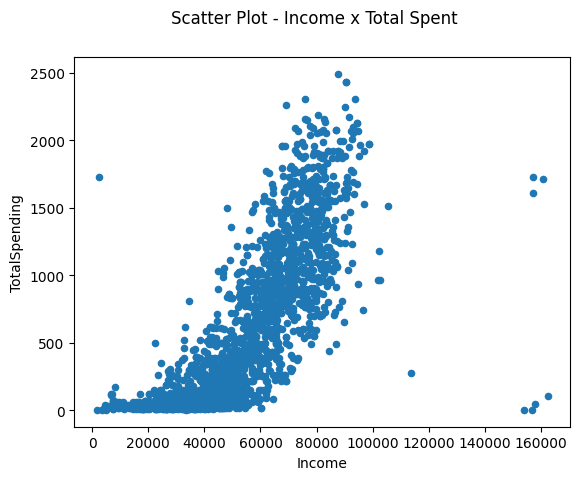

In [1018]:
import seaborn as sns
import matplotlib.pyplot as plt

df[["Income", "TotalSpending"]].plot.scatter(x='Income', y='TotalSpending')
plt.suptitle('Scatter Plot - Income x Total Spent')
plt.show()

- There is a positive correlation between income and total amount of consumed items, which was already noticed before

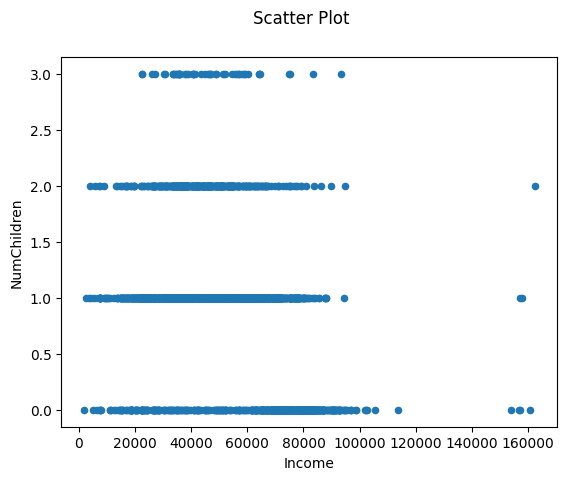

In [1019]:
df[["Income", "NumChildren"]].plot.scatter(x='Income', y='NumChildren')
plt.suptitle('Scatter Plot')
plt.show()

- Nothing special about the correlation between income and number of children

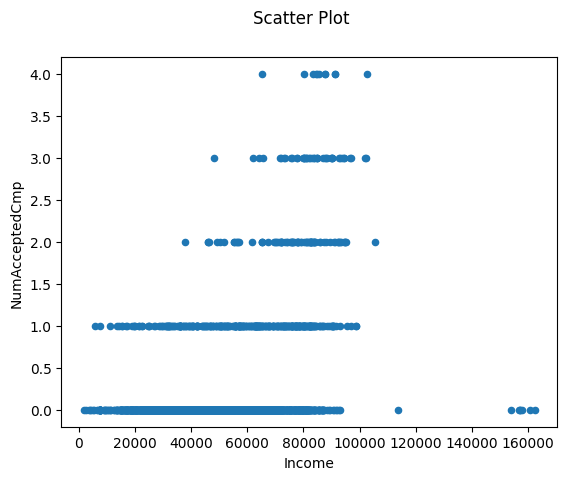

In [1020]:
df[["Income", "NumAcceptedCmp"]].plot.scatter(x='Income', y='NumAcceptedCmp')
plt.suptitle('Scatter Plot')
plt.show()

- It looks like there is a smooth positive correlation between the income and the amount of accepted campaigns

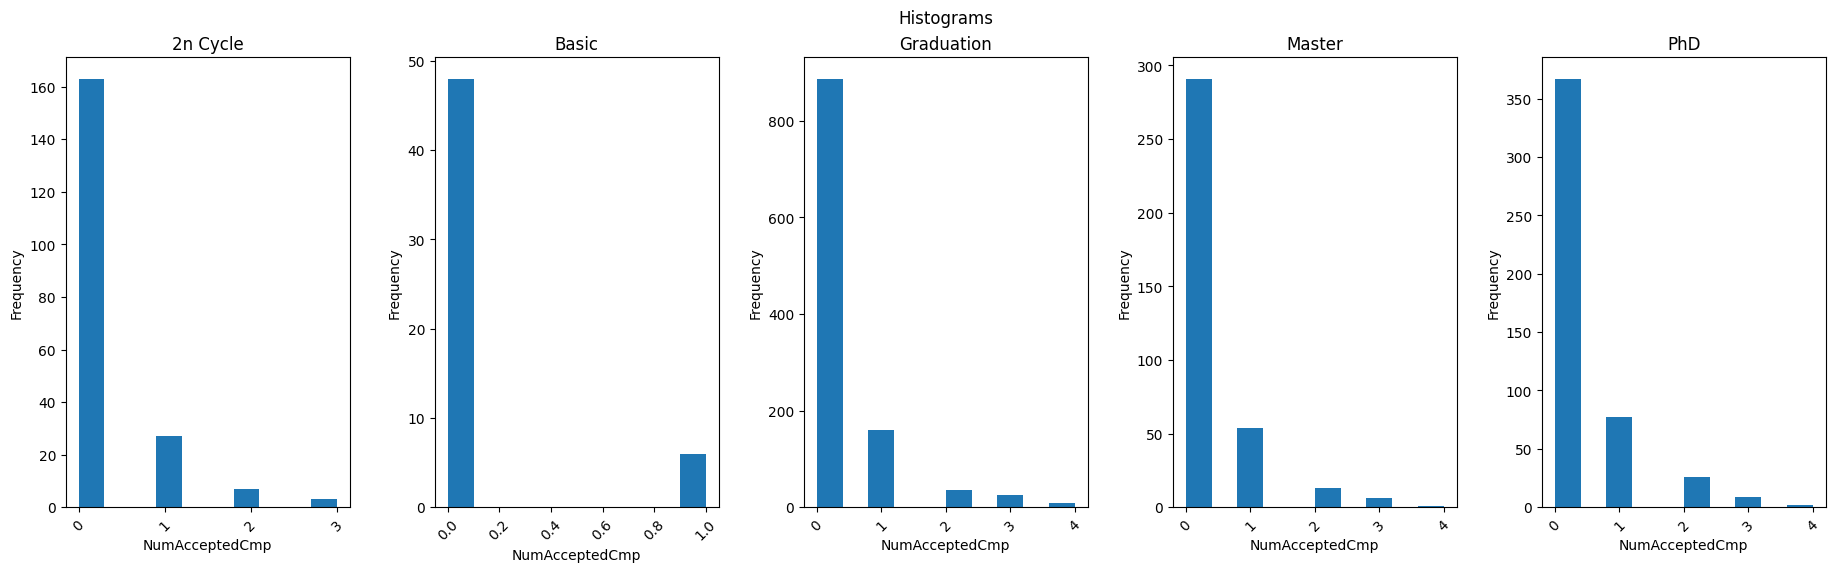

In [1021]:
axs = df.hist(column="NumAcceptedCmp", by="Education", xrot=45, figsize=(22, 6), layout=(1, 5))

for ax in axs:
    ax.set_xlabel('NumAcceptedCmp')
    ax.set_ylabel('Frequency')
plt.suptitle('Histograms')
plt.show()

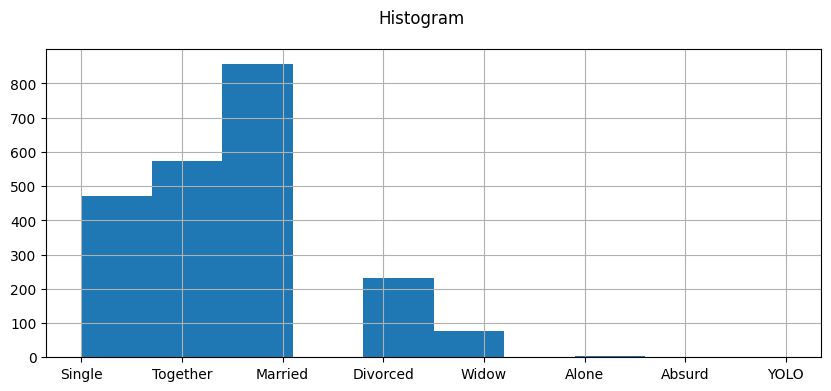

In [1022]:
df['Marital_Status'].hist(figsize=(10, 4))
plt.suptitle('Histogram')
plt.show()

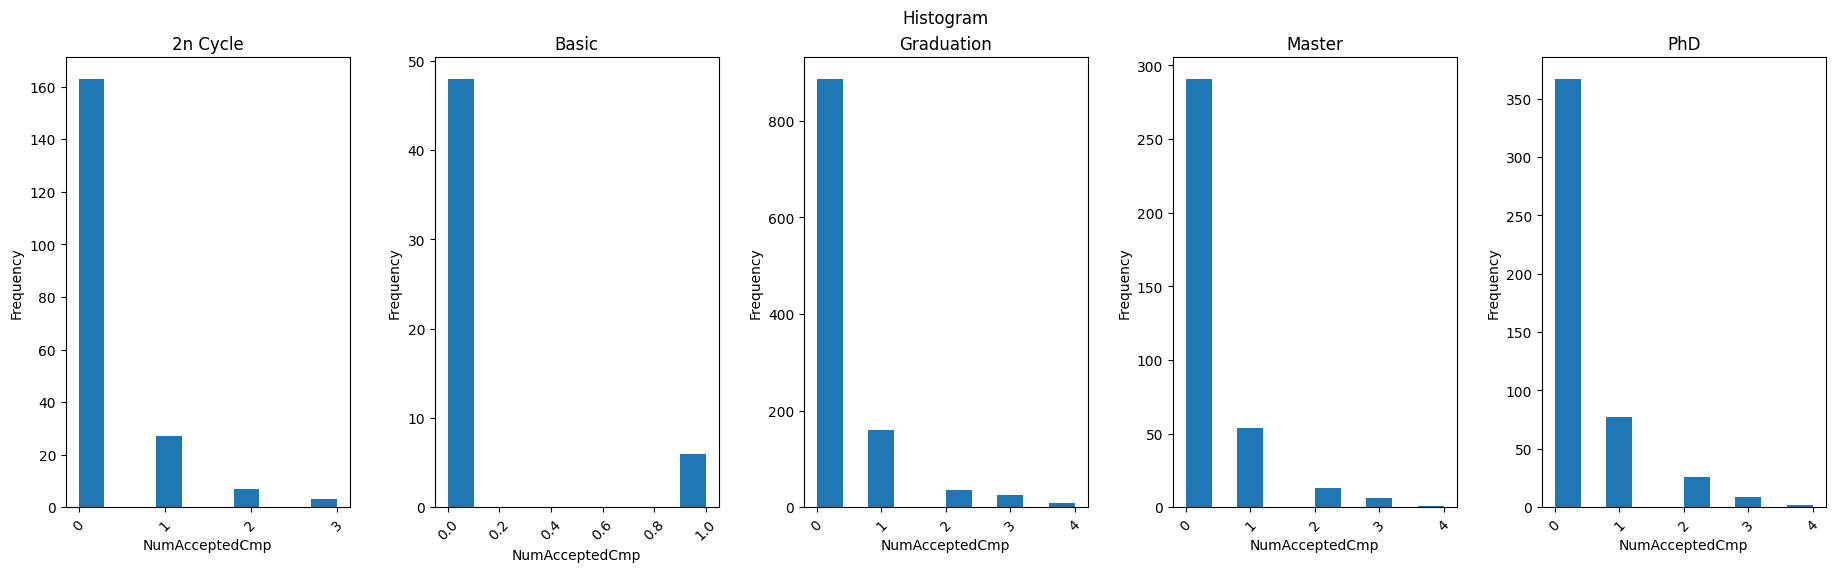

In [1023]:
axs = df.hist(column="NumAcceptedCmp", by="Education", xrot=45, figsize=(22, 6), layout=(1, 5))

for ax in axs:
    ax.set_xlabel('NumAcceptedCmp')
    ax.set_ylabel('Frequency')
plt.suptitle('Histogram')
plt.show()

 - Does clients that visit the website more often spend more?

 Not at first sight.

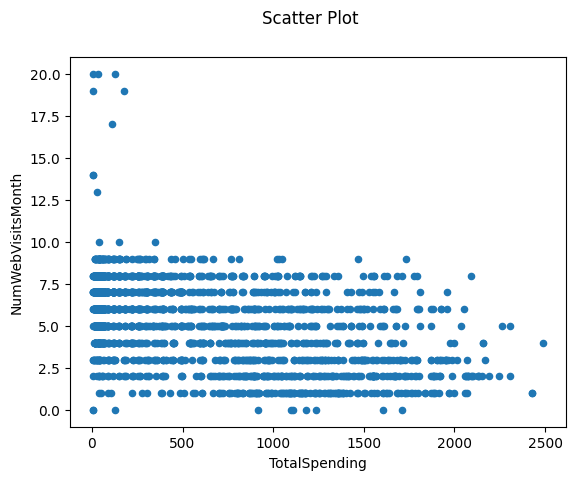

In [1024]:
df[["NumWebVisitsMonth", "TotalSpending"]].plot.scatter(x='TotalSpending', y='NumWebVisitsMonth')
plt.suptitle('Scatter Plot')
plt.show()

In [1025]:
grouped_df = df.groupby(by="SalaryRange")[["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds", "TotalSpending"]].sum()
grouped_df

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,TotalSpending
SalaryRange,,,,,,,
0,789,414,2588,542,447,1974,4780
1,77010,7100,35287,11420,7282,21901,138099
2,527377,44633,275558,62959,44913,67149,955440
3,70898,6244,56612,8476,7253,6391,149483


In [1026]:
grouped_df.div(grouped_df["TotalSpending"], axis=0) * 100

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,TotalSpending
SalaryRange,,,,,,,
0,16.506276,8.661088,54.142259,11.338912,9.351464,41.297071,100.0
1,55.764343,5.141239,25.551959,8.269430,5.273029,15.858913,100.0
2,55.197291,4.671460,28.840953,6.589529,4.700766,7.028071,100.0
3,47.428805,4.177064,37.871865,5.670210,4.852057,4.275403,100.0


- Class B, C, D consume a similar amount of wine
- Class E don't consume a lot of wine
- Class E consume fruits the most, 2x more than the other classes
- Class B consume meat the most
- Class E consume fish the most, 2x more than class B
- Class E consume sweets the most, almost 2x more than the other classes
- Class B barely consumes gold products, while class E consumes the most of gold products, more than 10x more than class B

---

- Class B prefers wines and meat
- Class C prefers wines and meat
- Class D prefers wines, meat, and gold products
- Class E prefers gold products, wines, meat, and fish in this order 

In [1027]:
grouped_df = df.groupby(by="AgeGroup")[["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds", "TotalSpending"]].sum()
grouped_df

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,TotalSpending
AgeGroup,,,,,,,
0,191242,20510,125917,29196,20975,32097,387840
1,359532,29111,181579,40117,29268,48841,639607
2,125300,8770,62549,14084,9652,16477,220355


In [1028]:
grouped_df.div(grouped_df["TotalSpending"], axis=0) * 100

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,TotalSpending
AgeGroup,,,,,,,
0,49.309509,5.288263,32.466223,7.527847,5.408158,8.275835,100.0
1,56.211392,4.551389,28.389151,6.272133,4.575935,7.636095,100.0
2,56.862790,3.979941,28.385560,6.391505,4.380205,7.477480,100.0


- Old people consume more wine than middle and young people, young consuming the least
- Young people consume fruits more than the other ages
- Young people consume meat mot than the other two ages. Those other two consume similar amounts of meat.
- The three ages consume similar amounts of fish.
- The three ages consume similar amounts of sweet, with the young consuming slightly more.
- Middle age people consume gold products the most, with the other two consuming similar amounts of gold product.

In [1029]:
grouped_df = df.groupby(by=["AgeGroup", "SalaryRange"])[["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds", "TotalSpending"]].sum()
grouped_df

MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
AgeGroup SalaryRange                                                          
0        0                 440        316             2334              348   
         1               20624       3012            13521             4872   
         2              141758      14469            85456            20569   
         3               28420       2713            24606             3407   
1        0                 303         86              212              168   
         1               43629       3409            16635             4790   
         2              285486      22899           140724            31341   
         3               30114       2717            24008             3818   
2        0                  46         12               42               26   
         1               12757        679             5131             1758   
         2              100133       7265            49378            11049   
         3               12364        814             7998             1251   

                      MntSweetProducts  MntGoldProds  TotalSpending  
AgeGroup SalaryRange                                                 
0        0                         350          1066           3788  
         1                        3239          8630          45268  
         2                       14226         19733         276478  
         3                        3160          2668          62306  
1        0                          85           864            854  
         1                        2974         10427          71437  
         2                       23333         35094         503783  
         3                        2876          2456          63533  
2        0                          12            44            138  
         1                        1069          2844          21394  
         2                        7354         12322         175179  
         3                        1217          1267          23644

In [1030]:
grouped_df.div(grouped_df["TotalSpending"], axis=0) * 100

MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
AgeGroup SalaryRange                                                           
0        0            11.615628   8.342133        61.615628         9.186906   
         1            45.559777   6.653707        29.868781        10.762570   
         2            51.272796   5.233328        30.908788         7.439652   
         3            45.613585   4.354316        39.492184         5.468173   
1        0            35.480094  10.070258        24.824356        19.672131   
         1            61.073393   4.772037        23.286252         6.705209   
         2            56.668447   4.545409        27.933455         6.221131   
         3            47.398990   4.276518        37.788236         6.009475   
2        0            33.333333   8.695652        30.434783        18.840580   
         1            59.628868   3.173787        23.983360         8.217257   
         2            57.160390   4.147187        28.187169         6.307263   
         3            52.292336   3.442734        33.826764         5.290983   

                      MntSweetProducts  MntGoldProds  TotalSpending  
AgeGroup SalaryRange                                                 
0        0                    9.239704     28.141499          100.0  
         1                    7.155165     19.064240          100.0  
         2                    5.145437      7.137277          100.0  
         3                    5.071743      4.282092          100.0  
1        0                    9.953162    101.170960          100.0  
         1                    4.163109     14.596078          100.0  
         2                    4.631558      6.966095          100.0  
         3                    4.526781      3.865708          100.0  
2        0                    8.695652     31.884058          100.0  
         1                    4.996728     13.293447          100.0  
         2                    4.197992      7.033948          100.0  
         3                    5.147183      5.358653          100.0

- Less than 15% of middle age and young people from salary class E consume wine. On the other hand, more than 30% from all the other age or salary range consume wine. In special, more than 50% of old people consume wine considering any salary range, except by salary class E which is ~34%. The insight is that for young people, the wine consumption increase as we increase the salary range. For middle age people, class E doesn't consume as much wine as salary class D, C, and B. 
- Young people from salary class E consume considerably more fruits (at least 2x more) than the other classes and ages.
- For the meat consumption, the higher the salary class, the consumption increase regardless of age. The consumption difference between class E and B is almost 2.5x for all the three ages.
- For the fish consumption, the smaller the salary class, higher the consumption of fish regardless of age. For old people, class E consumes almost 3x more fish than class B.
- For sweet, young people from class E consume 2x more than all the other ages and classes.
- For gold product consumption, the smaller the salary class, more gold product is consumed. In special, middle age people from class E consumes the most compared to all classes and ages. In special, it consumes more than 10x more gold product than class B from the middle age. 

In [1031]:
df.columns

Index(['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4',
       'AcceptedCmp5', 'Complain', 'Education', 'ID', 'Income', 'Kidhome',
       'Marital_Status', 'MntFishProducts', 'MntFruits', 'MntGoldProds',
       'MntMeatProducts', 'MntSweetProducts', 'MntWines',
       'NumCatalogPurchases', 'NumDealsPurchases', 'NumStorePurchases',
       'NumWebPurchases', 'NumWebVisitsMonth', 'Recency', 'Response',
       'Teenhome', 'Year_Birth', 'Z_CostContact', 'Z_Revenue', 'MntRegProds',
       'TotalSpending', 'Days_With_Company', 'NumTotalPurchases',
       'NumAcceptedCmp', 'CustomerAge', 'AgeGroup', 'NumChildren',
       'SalaryRange', 'Current Campaign'],
      dtype='object')

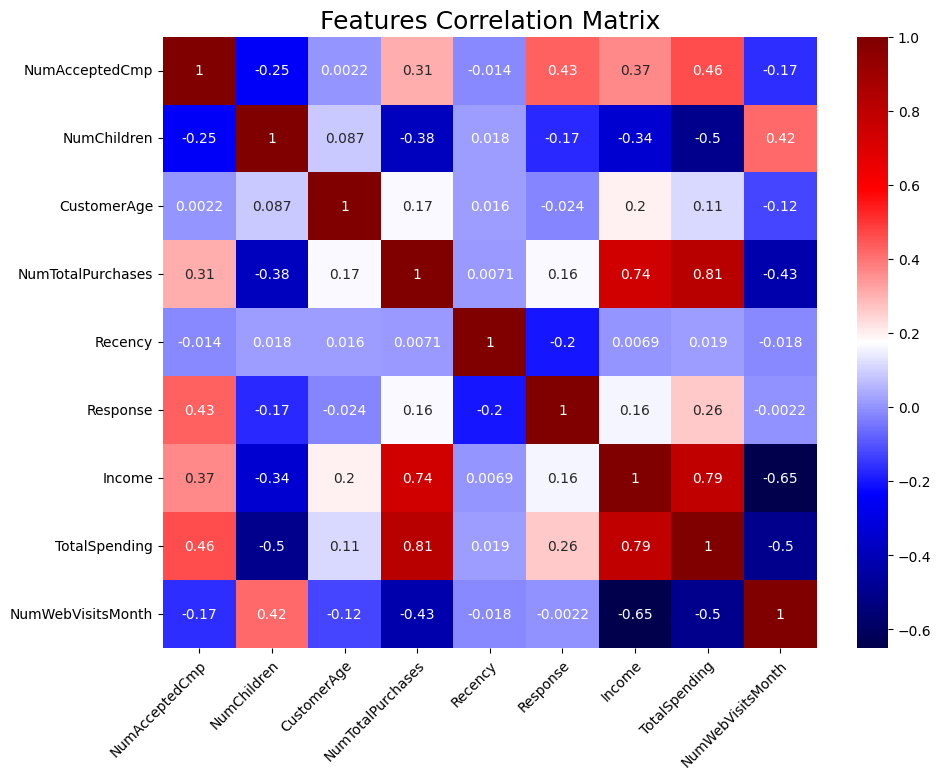

3 pairs with correlation coefficient above 0.70:
	- `TotalSpending` and `NumTotalPurchases`: correlation = 0.81
	- `TotalSpending` and `Income`: correlation = 0.79
	- `Income` and `NumTotalPurchases`: correlation = 0.74


In [1032]:
corr_data = df[["NumAcceptedCmp", "NumChildren", "CustomerAge", "NumTotalPurchases", "Recency", "Response", "Income", "TotalSpending", "NumWebVisitsMonth"]]
plot_correlation_matrix(
    corr_data,
    correlation_threshold=0.7,
    figsize=(10, 8), annot=True,
    title='Features Correlation Matrix'
)

- Positive high correlation between Total Spent (`TotalSpending`) and Total Purchases (`NumTotalPurchases`)
- Positive high correlation between Total Spent (`TotalSpending`) and Income (`Income`)
- Positive high correlation between Current Campaing Acceptance (`Response`) and Total number of campaigns accepted (`NuMAcceptedCmp`)
- Negative high correlation between `Income` and web visits (`NumWebVisitsMonth`)

## Data Cleaning


In [1033]:
df.dropna(inplace=True)
df.drop(columns=["ID", "Z_CostContact", "Z_Revenue", "SalaryRange", "AgeGroup",], inplace=True)

In [1034]:
df = df[df["Income"] <= 200000] # drop outliers

We'll drop births smaller than 1940.

In [1035]:
df = df[df['Year_Birth'] >= 1940]

In [1036]:
df[df["Marital_Status"] == "Alone"]["Marital_Status"] = "Single"
df[df["Marital_Status"] == "Married"]["Marital_Status"] = "Together"
df = df[(df["Marital_Status"] == "Single") | (df["Marital_Status"] == "Together") | (df["Marital_Status"] == "Widow")]

/tmp/ipykernel_140430/3358864814.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_140430/3358864814.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [1037]:
df['Education'].value_counts()

Education
Graduation    565
PhD           235
Master        188
2n Cycle       96
Basic          33
Name: count, dtype: int64

In [1038]:
18 / 142

0.1267605633802817

In [1039]:
def plot_accepted_cmp(column):
    ncmps = 5
    nrows = 6
    ncols = 2
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 34))

    def plot_num_acc(cmp, num_acc, ax):
        df[df[cmp] == num_acc][column].hist(ax=ax)
        ax.set_xlabel(cmp + " = " + str(num_acc))
        ax.set_ylabel('Frequency')
        ax.grid(True)

    for i in range(ncmps):
        ax = axs[i // ncols, i % ncols]
        plot_num_acc(f'AcceptedCmp{i + 1}', 1, ax)

    plot_num_acc(f'Response', 1, axs[2, 1])
    plot_num_acc(f'NumAcceptedCmp', 0, axs[3, 0])
    plot_num_acc(f'NumAcceptedCmp', 1, axs[3, 1])
    plot_num_acc(f'NumAcceptedCmp', 2, axs[4, 0])
    plot_num_acc(f'NumAcceptedCmp', 3, axs[4, 1])
    plot_num_acc(f'NumAcceptedCmp', 4, axs[5, 0])
    plot_num_acc(f'NumAcceptedCmp', 5, axs[5, 1])

    plt.show()

In [1040]:
acc1 = df[df['AcceptedCmp1'] == 1]['Education'].value_counts()
# acc1 = pd.DataFrame(acc1, columns=["AcceptedCmp1"])
acc1

Education
Graduation    38
PhD           16
Master         8
2n Cycle       5
Name: count, dtype: int64

In [1041]:
acc1 = df[df['AcceptedCmp1'] == 1]['Education'].value_counts()
acc2 = df[df['AcceptedCmp2'] == 1]['Education'].value_counts()
acc3 = df[df['AcceptedCmp3'] == 1]['Education'].value_counts()
acc4 = df[df['AcceptedCmp4'] == 1]['Education'].value_counts()
acc5 = df[df['AcceptedCmp5'] == 1]['Education'].value_counts()
response = df[df['Response'] == 1]['Education'].value_counts()
total = acc1 + acc2 + acc3 + acc4 + acc5 + response

tmp_df = pd.DataFrame([acc1, acc2, acc3, acc4, acc5, response, total]).T.fillna(0)
tmp_df.columns = ["AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "Response", "Total"]
tmp_df

,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response,Total
Education,,,,,,,
Graduation,38.0,10.0,38.0,42.0,46.0,89.0,263.0
PhD,16.0,6.0,19.0,19.0,15.0,49.0,124.0
Master,8.0,2.0,11.0,18.0,17.0,35.0,91.0
2n Cycle,5.0,0.0,7.0,5.0,3.0,9.0,0.0
Basic,0.0,0.0,4.0,0.0,0.0,2.0,0.0


In [1042]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [1043]:
variables_to_compare = ['Income', 'TotalSpending', 'NumTotalPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'NumAcceptedCmp']
comparison_results_mean = df.groupby('Response')[variables_to_compare].mean()
comparison_results_mean

,Income,TotalSpending,NumTotalPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,NumAcceptedCmp
Response,,,,,,,,
0,50362.436227,502.061093,11.965702,3.828510,2.426581,5.710611,5.23687,0.171490
1,59905.250000,941.342391,15.266304,5.086957,4.103261,6.076087,5.37500,0.918478


Percentage of clients that accepted each campaign

In [1044]:
(df[campaign_columns].sum() / len(df)) * 100

AcceptedCmp1         5.998209
AcceptedCmp2         1.611459
AcceptedCmp3         7.072516
AcceptedCmp4         7.520143
AcceptedCmp5         7.251567
Current Campaign    16.472695
dtype: float64

In [1045]:
df[df["Response"] == 1]['Education'].value_counts() / df[df["Response"] == 1]['Education'].value_counts().sum() * 100

Education
Graduation    48.369565
PhD           26.630435
Master        19.021739
2n Cycle       4.891304
Basic          1.086957
Name: count, dtype: float64

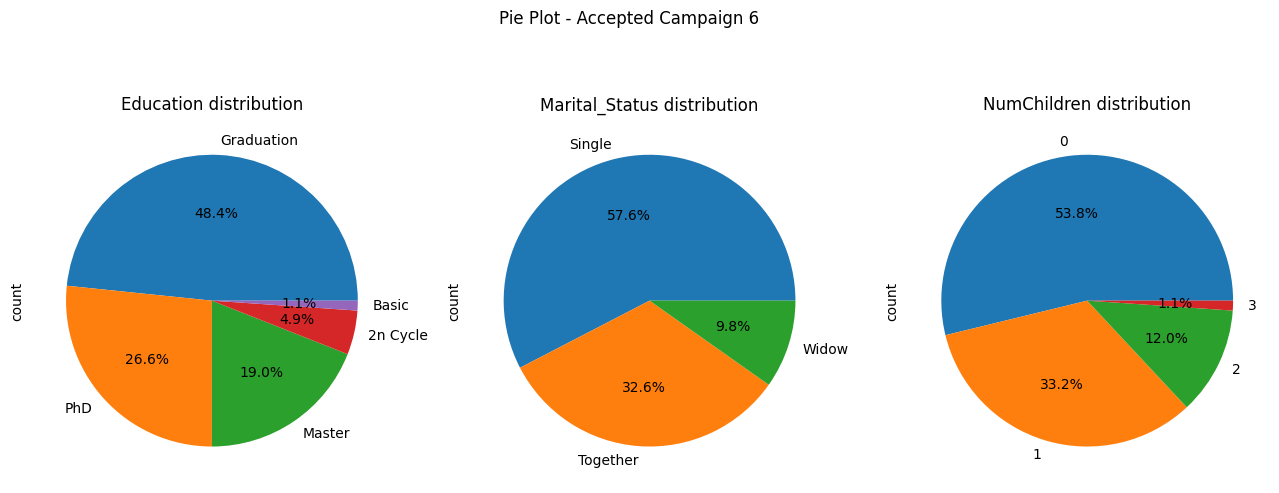

In [1046]:
columns = ["Education", "Marital_Status", "NumChildren"]
fig, axs = plt.subplots(nrows=1, ncols=len(columns), figsize=(16, 6))

for i, column in enumerate(columns):
    ax = axs[i]
    (df[df["Response"] == 1][column].value_counts()).plot.pie(autopct='%1.1f%%', title=column + " distribution", startangle=0, ax=ax)
plt.suptitle('Pie Plot - Accepted Campaign 6')
plt.show()